In [3]:
import pandas as pd
import numpy as np
#from google.colab import files
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR 

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_extraction.settings import from_columns, TimeBasedFCParameters

from tsfresh.transformers import RelevantFeatureAugmenter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import sktime
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError



c:\Users\M.R.S\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\M.R.S\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\M.R.S\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\M.R.S\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas

In [4]:
data = pd.read_csv('../train.csv')           # Archivo que contiene el dataset del proyecto

In [5]:
asset_details = pd.read_csv('../asset_details.csv')  # Archivo con la información del nombre real de la criptomoneda junto con su ID
                                                  # Contiene también el "Peso" que cada criptomoneda recibe en la metrica.

No handles with labels found to put in legend.


<BarContainer object of 14 artists>

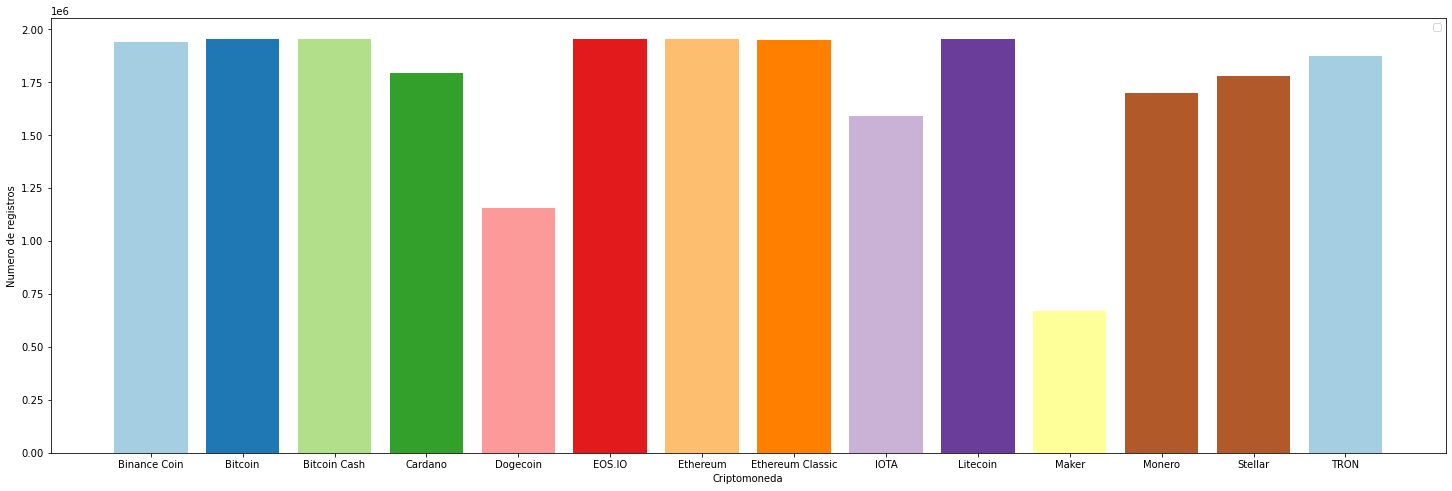

In [6]:
asset_count= []
for i in range(14):
    count = (data["Asset_ID"]==i).sum()
    asset_count.append(count)

colors = plt.get_cmap('Paired')

plt.figure(figsize=(25,8))

plt.legend()
plt.xlabel('Criptomoneda')
plt.ylabel('Numero de registros')
plt.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             height= asset_count, color = colors(range(13))) 


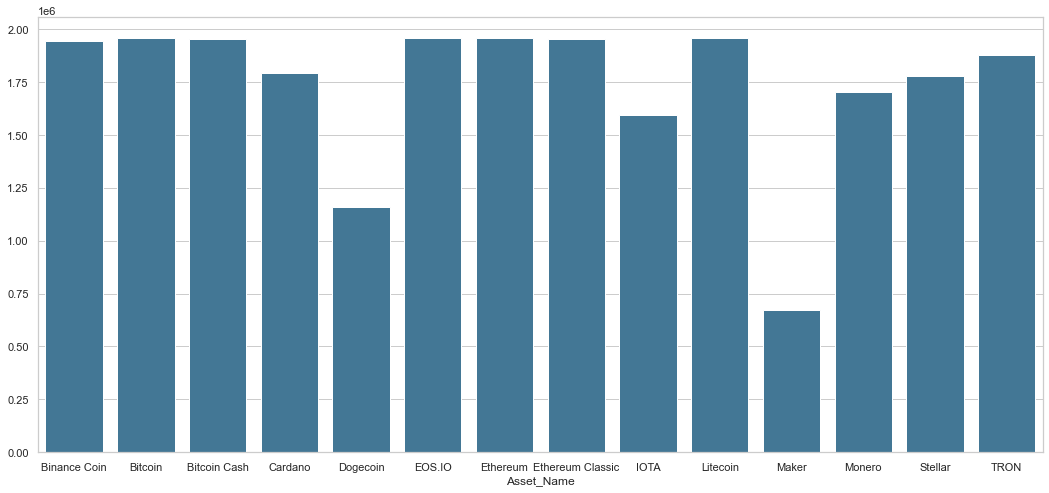

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18,8))
pal = sns.color_palette("mako", 1)

ax = sns.barplot(x=asset_details.sort_values("Asset_ID")["Asset_Name"], y=asset_count, data=asset_details,
                 palette=pal)

In [8]:
#Se selecciona la criptomoneda Bitcoin para el análisis inicial
bitcoin = data[data["Asset_ID"]==1].set_index("timestamp") 
bitcoin.shape 

(1956282, 9)

In [9]:
def reindexar(cripto):
    return cripto.reindex(range(cripto.index[0],cripto.index[-1]+60,60),method='pad')

In [10]:
bitcoin = reindexar(bitcoin)

In [11]:
y = bitcoin.Target

In [79]:
days = 1
test_size = 0.1
total_minutes = days*1440
train_minutes = int(total_minutes*(1-test_size))
test_minutes = total_minutes - train_minutes

X_train_new = bitcoin.iloc[int(-1*total_minutes):int(-1*test_minutes)]
X_train_new = X_train_new.drop(['Target'], axis = 1)
y_train_new = y.iloc[int(-1*total_minutes):int(-1*test_minutes)]

X_test_new = bitcoin.iloc[int(-1*test_minutes):-16]
X_test_new = X_test_new.drop(['Target'], axis = 1)
y_test_new = y.iloc[int(-1*test_minutes):-16]

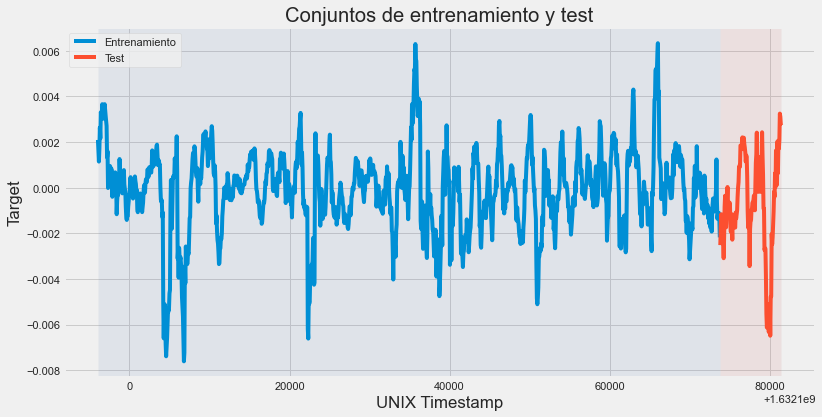

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

plt.xlabel("UNIX Timestamp")
plt.ylabel("Target")
plt.title("Conjuntos de entrenamiento y test")

plt.plot(y_train_new.index, y_train_new, label='Entrenamiento')
plt.plot(y_test_new.index, y_test_new, label='Test')
plt.legend(loc='best')

plt.axvspan(y_test_new.index[0], y_test_new.index[-1],  facecolor='r', alpha=0.1)
plt.axvspan(y_train_new.index[0], y_train_new.index[-1],  facecolor='b', alpha=0.1)


In [14]:
scaler2 = MinMaxScaler()
X_train_scaled_new = scaler2.fit_transform(X_train_new)
X_test_scaled_new = scaler2.fit_transform(X_test_new)

In [15]:
# SMAPE proposed by Makridakis (1993): 0%-200%
smape = MeanAbsolutePercentageError(symmetric=True)

def smape_original(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


# adjusted SMAPE version to scale metric from 0%-100%
def smape_adjusted(a, f):
    return 100*(1/a.size * np.sum(np.abs(f-a) / (np.abs(a) + np.abs(f))))



Modelo Baseline

In [16]:
reg = RandomForestRegressor(n_estimators=30)

#reg =LinearSVR(random_state=0, tol=1e-5)
#reg = KNeighborsRegressor(n_neighbors=10)
reg.fit(X_train_new, y_train_new)

RandomForestRegressor(n_estimators=30)

In [19]:
y_pred = reg.predict(X_test_new)
print(100*smape(y_test_new, y_pred)) 

128.42923486754182


c:\Users\M.R.S\anaconda3\lib\site-packages\sktime\performance_metrics\forecasting\_functions.py:1543: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  warn(


In [21]:
p = np.corrcoef(y_test_new, y_pred)
print(p[0][1]) 

-0.11168651708682835


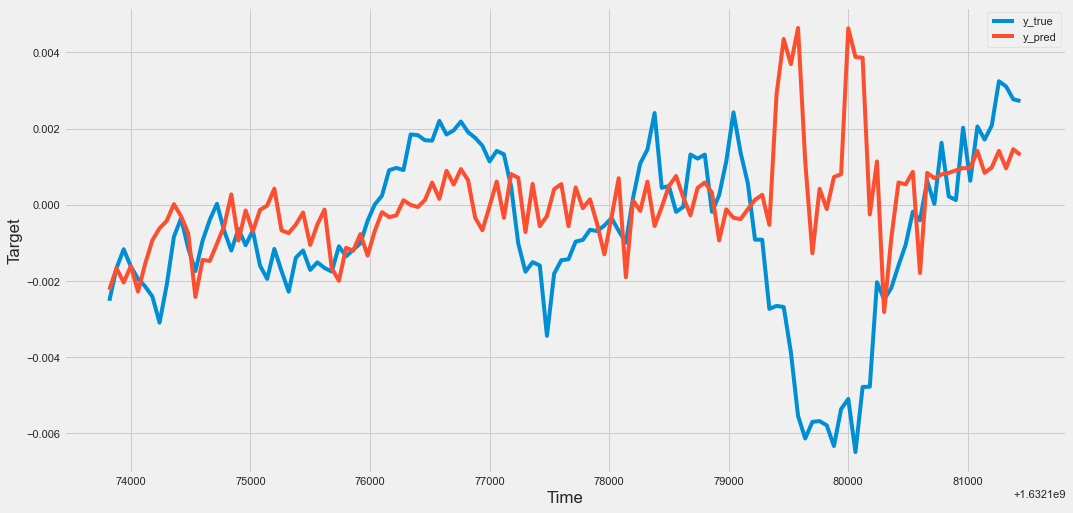

In [24]:
fig, ax=plt.subplots(figsize=(16, 8))

seccion_true = y_test_new[-500:]
seccion_pred = y_pred[-500:]

plt.xlabel("Time")
plt.ylabel("Target")

plt.plot(seccion_true.index, seccion_true, label='y_true')
plt.plot(seccion_true.index, seccion_pred, label='y_pred')
plt.legend(loc='best')
plt.show()


USANDO SKFORECAST

In [91]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster



In [92]:
predicciones = pd.read_csv('y_pred_2_knn.csv')

In [93]:
predicciones.shape

(128, 2)

In [94]:
y_test_new = y_test_new.reset_index()

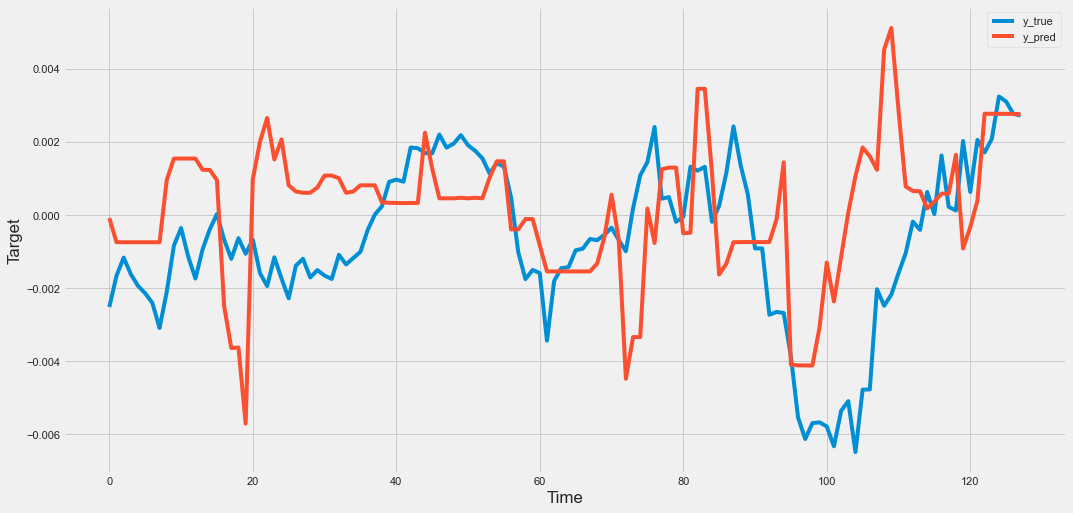

In [95]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(16, 8))

plt.xlabel("Time")
plt.ylabel("Target") 

plt.plot(y_test_new.index, y_test_new['Target'], label='y_true')
plt.plot(y_test_new.index, predicciones['pred'], label='y_pred')

plt.legend(loc='best')
plt.show()

